# E-commerce Product recommendation System

Product Recommendation System is a machine learning-based project that provides personalized product recommendations to users based on their browsing and purchase history. The system utilizes collaborative filtering and content-based filtering algorithms to analyze user behavior and generate relevant recommendations. This project aims to improve the overall shopping experience for users, increase sales for e-commerce businesses

### Importing libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

from scipy.sparse.linalg import svds # for sparse matrices

### Importing Dataset

### EDA - Exploratory Data Analysis
check for -

- shape
- datatype
- missing values
finally get the summary and check

- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [2]:
#Import the data set
df = pd.read_csv(r"C:\Documentss\Projects\Ecommerce product recommendation system\ratings_Electronics.csv", header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

In [3]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


### Datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### Missing value analysis

In [5]:
# Find number of missing values in each column
df.isna().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

### Summary

In [6]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

### Rating distribution

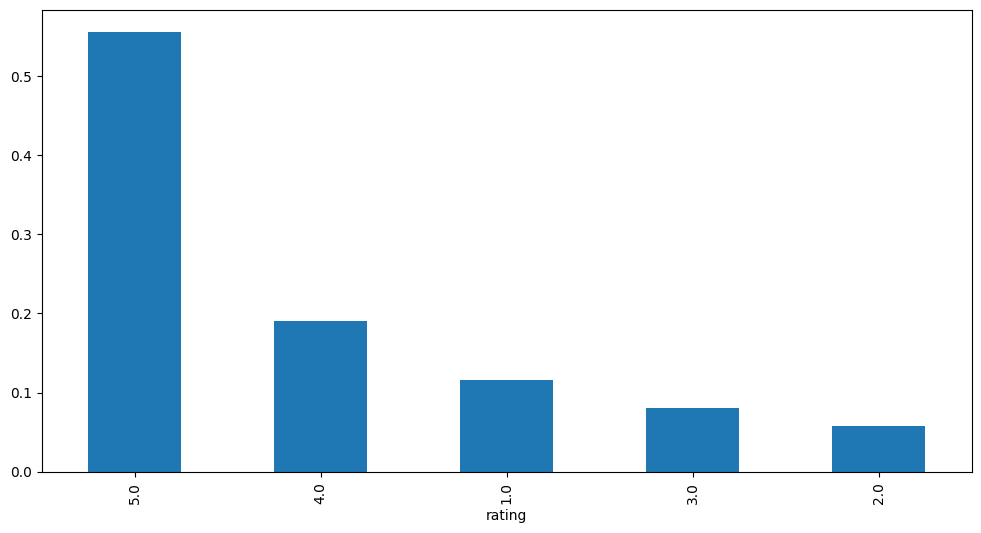

In [7]:
#Create the plot and provide observations

plt.figure(figsize = (12,6))
df['rating'].value_counts(1).plot(kind='bar')
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [8]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### Users with most no of rating

In [9]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

### Pre-Processing
Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [10]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [11]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- The dataframe df_final has users who have rated 50 or more items
- We will use df_final to build recommendation systems

### Checking the density of the rating matrix

In [12]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix 
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Collaborative Filtering based Recommendation System
### User based collaborative filtering

In [13]:
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here, user_id (index) is of the object data type. We will replace the user_id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format

In [14]:
final_ratings_matrix['user_index'] = np.arange(0, final_ratings_matrix.shape[0])
final_ratings_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Function to find Similar users and their similarity scores

In [15]:
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows
        
        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])
        
        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))
        
    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list
   
    #Remove the original user and its similarity score and keep only other similar users 
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])
       
    return most_similar_users, similarity_score

### Finding out top 10 similar users to the user index 3 and their similarity score

In [16]:
similar = similar_users(3,final_ratings_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [17]:
#Print the similarity score
similar_users(3,final_ratings_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

### Finding out top 10 similar users to the user index 1521 and their similarity score

In [18]:
similar = similar_users(1521, final_ratings_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [19]:
#Print the similarity score
similar_users(1521,final_ratings_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

### Function to recommend products

In [20]:
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):
    
    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]
    
    #Finding product IDs with which the user_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:
            
            #Finding 'n' products which have been rated by similar users but not by the user_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break
    
    return recommendations[:num_of_products]

### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [21]:
recommendations(3,5,final_ratings_matrix)

['B000H2486S', 'B00007M1TZ', 'B0013DXVYK', 'B00015Y0FK', 'B0002L5R78']

### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [22]:
recommendations(1521,5,final_ratings_matrix)

['B00G4FCKB2', 'B00EU9V3S0', 'B007BY0MIS', 'B005TDWUII', 'B007XOQUY6']

# Rank Based Recommendation System

In [28]:
# Ensure the 'rating' column is numeric, coercing errors to NaN
df_final['rating'] = pd.to_numeric(df_final['rating'], errors='coerce')

# Drop rows where 'rating' is NaN (i.e., rows with non-numeric ratings)
df_final = df_final.dropna(subset=['rating'])

# Calculate the average rating for each product, selecting only the 'rating' column for mean
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# Display the top results
final_rating.head()


,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [29]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
    
    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values('avg_rating',ascending=False)
    
    return recommendations.index[:n]

### Recommending top 5 products with 50 minimum interactions based on popularity

In [30]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### Recommending top 5 products with 100 minimum interactions based on popularity

In [31]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']